In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt

In [74]:
# makes a noisy sine wave which we will try to fit a model to
A = 1
B = 3
C = 0
N = 100
x = np.linspace(0,2*np.pi,N)
y = A * np.sin(B * x) + C
y_noisy = y.copy()

deviation = 0.2
for i in range(len(y_noisy)):
    noise = np.random.uniform(-deviation, deviation)
    y_noisy[i] += noise

data_out = np.row_stack([x, y_noisy])
np.savetxt("./datasets/noisy_sine.csv", data_out, delimiter=",")

In [75]:
class SinusoidalDataset(Dataset):
    def __init__(self, path):
        data = np.loadtxt(path,delimiter=",")
        self.inputs = torch.from_numpy(data[0,:]).float()
        self.outputs = torch.from_numpy(data[1,:]).float()

    def __len__(self):
        return (len(self.inputs))

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

    def scatter_plot(self):
        x = self.inputs.numpy()
        y = self.outputs.numpy()
        plt.figure(figsize=(5,3))
        plt.scatter(x,y)
        plt.grid()
        plt.show()

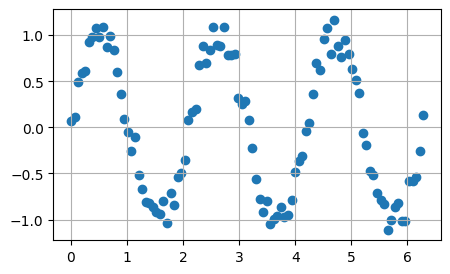

In [76]:
# load the dataset
training_data = SinusoidalDataset("./datasets/noisy_sine.csv")

# Show a plot of the raw data
training_data.scatter_plot()

# Create a DataLoader
dataloader = DataLoader(training_data)

In [77]:
class SinusoidalModel(torch.nn.Module):
    '''
    Sinusoid of the form a*sin(b*x) + c
    '''
    def __init__(self,w0=[]):
        super().__init__()
        if len(w0) == 0:
            self.a = torch.nn.Parameter(torch.randn(()))
            self.b = torch.nn.Parameter(torch.randn(()))
            self.c = torch.nn.Parameter(torch.randn(()))
        else:
            self.a = torch.nn.Parameter(torch.tensor(w0[0], dtype=torch.float32, requires_grad=True))
            self.b = torch.nn.Parameter(torch.tensor(w0[1], dtype=torch.float32, requires_grad=True))
            self.c = torch.nn.Parameter(torch.tensor(w0[2], dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        return self.a * torch.sin(self.b*x) + self.c

In [88]:
# instatiate the model based on the size of the input data
# the initial guess needs to be pretty close to the real solution
model = SinusoidalModel([0.739452, 3.23412, 0.12])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

99: 0.01931733451783657
199: 0.01358362939208746
299: 0.012829038314521313
399: 0.012725967913866043
499: 0.01271180622279644
599: 0.01270986907184124
699: 0.012709596194326878
799: 0.012709562666714191
899: 0.012709558010101318
999: 0.012709550559520721


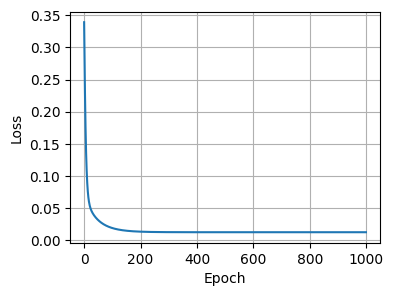

---------------
Found weights:
a = 1.0211827754974365
b = 3.0011258125305176
c = -0.00913387630134821


In [89]:
# Train the model
loss_hist = []
features = dataloader.dataset.inputs
labels = dataloader.dataset.outputs
num_epochs = 1000
for epoch in range(num_epochs):

    # Forward pass
    outputs = model(features.view(-1,1))

    # compuite the loss
    loss = criterion(outputs, labels.view(-1,1))
    loss_hist.append(loss.detach().float())
    if epoch % 100 == 99:
        print(f"{epoch}: {loss.item()}")

    # zero gradients, perform a backward pass, update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# plot loss history
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(list(range(num_epochs)), loss_hist)
ax.grid()
ax.set(xlabel="Epoch", ylabel="Loss")
plt.show()

a = model.a.item()
b = model.b.item()
c = model.c.item()
print("---------------")
print(f"Found weights:")
print(f"a = {model.a.item()}")
print(f"b = {model.b.item()}")
print(f"c = {model.c.item()}")


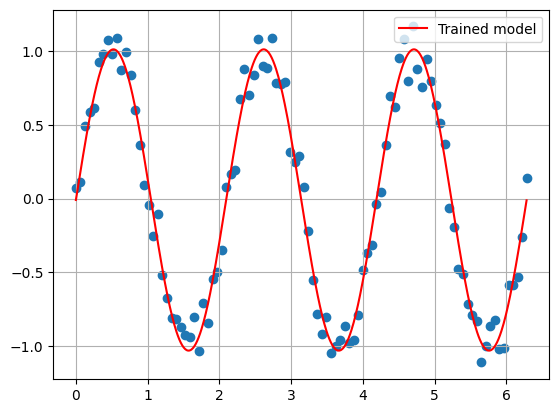

In [90]:
# Plot the trained model along with the raw data
xfit = np.arange(0,2*np.pi,0.01)
yfit = a*np.sin(b*xfit) + c
raw_x = dataloader.dataset.inputs.numpy().flatten()
raw_y = dataloader.dataset.outputs.numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(raw_x, raw_y)
ax.plot(xfit, yfit, "-r", label="Trained model")
ax.grid()
ax.set()
ax.legend()
plt.show()